In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [4]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10902 entries, 1976-08-02 to 2019-10-15
Data columns (total 8 columns):
Open                          10902 non-null float64
High                          10902 non-null float64
Low                           10902 non-null float64
Last                          10902 non-null float64
Change                        1415 non-null float64
Settle                        10902 non-null float64
Volume                        10902 non-null float64
Previous Day Open Interest    10902 non-null float64
dtypes: float64(8)
memory usage: 766.5 KB


In [5]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures=yen_futures.drop(columns='Change')
yen_futures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7515 entries, 1990-01-02 to 2019-10-15
Data columns (total 7 columns):
Open                          7515 non-null float64
High                          7515 non-null float64
Low                           7515 non-null float64
Last                          7515 non-null float64
Settle                        7515 non-null float64
Volume                        7515 non-null float64
Previous Day Open Interest    7515 non-null float64
dtypes: float64(7)
memory usage: 469.7 KB


# Data Preparation

### Returns
### &
### Lagged Returns 

In [6]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
yen_futures['Returns'] = (yen_futures[["Settle"]].pct_change() * 100)
yen_futures['Returns'] = yen_futures.Returns.replace(-np.inf, np.nan)
yen_futures['Lagged_Returns']=yen_futures.Returns.shift(1)
yen_futures=yen_futures.dropna()

### Train Test Split

In [7]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [8]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
X_train=train['Lagged_Returns'].to_frame()
X_test=test['Lagged_Returns'].to_frame()
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
Y_train=train['Returns']
Y_test=test['Returns']

In [9]:
X_train.head

<bound method NDFrame.head of             Lagged_Returns
Date                      
1990-01-04        0.584197
1990-01-05        1.756933
1990-01-08       -0.827626
1990-01-09        0.129496
1990-01-10       -0.632275
1990-01-11       -0.404917
1990-01-12        0.087121
1990-01-15       -0.290149
1990-01-16        0.349192
1990-01-17        0.000000
1990-01-18        0.000000
1990-01-19       -0.637959
1990-01-22        0.321027
1990-01-23       -0.480000
1990-01-24        0.380006
1990-01-25        0.232964
1990-01-26        1.002324
1990-01-29        0.992377
1990-01-30       -0.270578
1990-01-31       -1.342282
1990-02-01        0.434216
1990-02-02       -0.360282
1990-02-05       -0.433902
1990-02-06        0.493899
1990-02-07       -0.390286
1990-02-08       -0.145117
1990-02-09        0.130795
1990-02-12        0.391872
1990-02-13        0.303600
1990-02-14       -0.014413
...                    ...
2017-11-16        0.447339
2017-11-17       -0.095834
2017-11-20        0.76176

In [10]:
Y_train.head()

Date
1990-01-04    1.756933
1990-01-05   -0.827626
1990-01-08    0.129496
1990-01-09   -0.632275
1990-01-10   -0.404917
Name: Returns, dtype: float64

# Linear Regression Model

In [11]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [12]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [13]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = Y_test.to_frame()
Results["Predicted Return"] = predictions

In [14]:
Results.head(2)

,Returns,Predicted Return
Date,,
2018-01-02,0.297285,0.003815
2018-01-03,-0.240479,0.003046


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

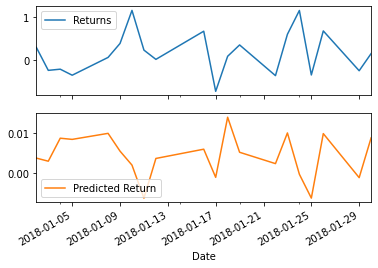

In [30]:
# Plot the first 20 predictions vs the true values
import warnings
warnings.filterwarnings("ignore")
Results[:20].plot(subplots=True,legend='top-right')


<AxesSubplot:xlabel='Date'>

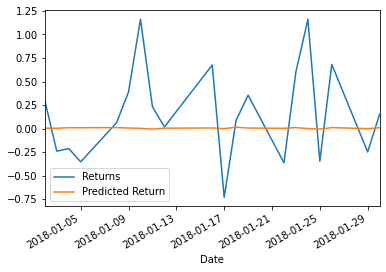

In [16]:
Results[:20].plot()

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [22]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Returns"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.4136504970669482


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [23]:
# Construct a dataframe using just the "y" training data:
in_sample_results = Y_train.to_frame()

# Add a column of "in-sample" predictions to that DataFrame:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Returns"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.7059387714146014


# Conclusions

YOUR CONCLUSIONS HERE!